In [57]:
import geopandas as gpd
import pandas as pd

# 设置投影坐标系为 UTM zone 49N（适合深圳）
target_crs = "EPSG:32650"

# 1. 读取原始轨迹数据（WGS84投影）
shp_2019 = gpd.read_file("Keep data/珠三角2019.shp")
shp_2020 = gpd.read_file("Keep data/珠三角2020.shp")

# 2. 确保原始坐标系为 EPSG:4326
if shp_2019.crs is None:
    shp_2019.set_crs("EPSG:4326", inplace=True)
if shp_2020.crs is None:
    shp_2020.set_crs("EPSG:4326", inplace=True)

# 3. 投影转换到 UTM 49N（EPSG:32649）
shp_2019_utm = shp_2019.to_crs(target_crs)
shp_2020_utm = shp_2020.to_crs(target_crs)

# 4. 合并数据
merged = gpd.GeoDataFrame(pd.concat([shp_2019_utm, shp_2020_utm], ignore_index=True), crs=target_crs)

# 5. 输出信息
print(f"合并后轨迹总条数：{len(merged)}")
print("示例记录：")
print(merged.head())

# 6. 保存为新的shp文件
merged.to_file("19to20Keep.shp", driver="ESRI Shapefile")


合并后轨迹总条数：58807
示例记录：
   FID                                           geometry
0    0  LINESTRING (346338.67 2537611.671, 346331.945 ...
1    1  LINESTRING (346433.303 2537611.8, 346435.682 2...
2    2  LINESTRING (346338.67 2537611.671, 346331.945 ...
3    3  LINESTRING (346433.303 2537611.8, 346435.682 2...
4    4  LINESTRING (347788.372 2514321.698, 347744.776...


In [58]:
import geopandas as gpd
from shapely.ops import unary_union

# 1. 读取深圳行政区划
admin = gpd.read_file("行政边界/深圳_县级区划.shp")

# 2. 坐标系统一（统一为 EPSG:32650）
admin = admin.to_crs("EPSG:32650")

# 3. 合并深圳所有县区边界并外扩1000米缓冲
shenzhen_union = unary_union(admin.geometry)
shenzhen_buffer = gpd.GeoDataFrame(geometry=[shenzhen_union.buffer(1000)], crs=admin.crs)

# 读取轨迹数据
merged = gpd.read_file("Keep data/19to20Keep.shp")

# 转换到 EPSG:32650
#merged = merged.to_crs("EPSG:32650")

# 裁剪
merged_in_sz = gpd.overlay(merged, shenzhen_buffer, how='intersection')

# 保存
merged_in_sz.to_file("19to20Keep_SZ.shp", driver="ESRI Shapefile")



# 处理运动轨迹|

In [59]:
import matplotlib.pyplot as plt
import matplotlib
# 设置支持中文的字体
matplotlib.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 可以选择其他支持中文的字体，例如 'SimHei'
matplotlib.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
import geopandas as gpd

# 读取轨迹Shapefile文件
gdf = gpd.read_file('Keep data/19to20Keep_SZ.shp')

# 设置坐标系为32649（如果需要转换）
gdf = gdf.to_crs(epsg=32650)

# 输出前五条记录的geometry列
print(gdf[['geometry']].head())


                                            geometry
0  MULTILINESTRING ((168244.119 2519738.927, 1682...
1  LINESTRING (168467.746 2519521.233, 168507.947...
2  MULTILINESTRING ((168764.65 2518007.428, 16873...
3  MULTILINESTRING ((168764.101 2517982.207, 1687...
4  MULTILINESTRING ((168764.626 2518006.332, 1686...


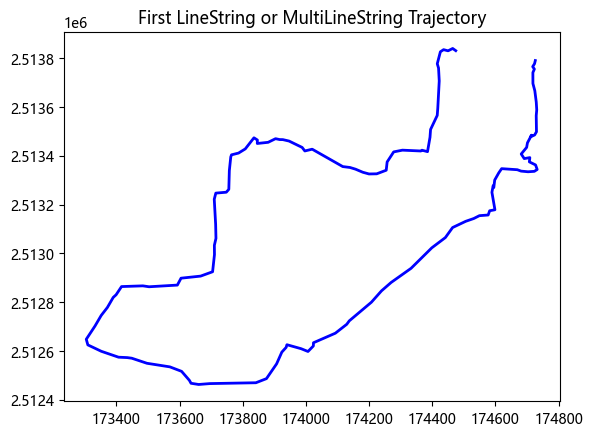

In [60]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString, MultiLineString

# 获取第一条轨迹的几何对象
geometry = gdf.loc[274, 'geometry']

# 创建图形
fig, ax = plt.subplots()

# 判断几何类型并绘制
if isinstance(geometry, LineString):
    # 提取LineString的坐标并绘制
    x, y = geometry.xy
    ax.plot(x, y, color='blue', linewidth=2)
elif isinstance(geometry, MultiLineString):
    # 如果是MultiLineString，使用geoms属性逐个绘制每条LineString
    for line in geometry.geoms:
        x, y = line.xy
        ax.plot(x, y, color='blue', linewidth=2)

# 添加标题
ax.set_title("First LineString or MultiLineString Trajectory")

# 显示图形
plt.show()


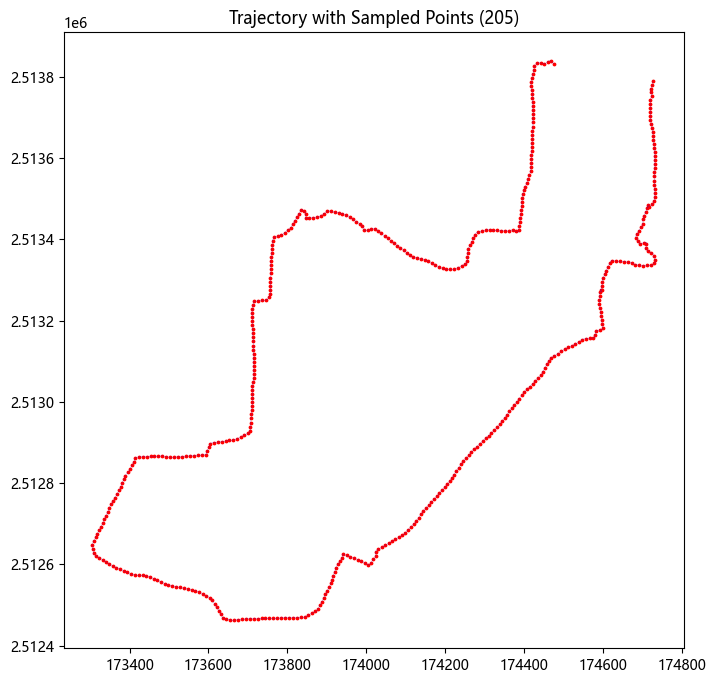

In [64]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import LineString, MultiLineString, Point

# 设定采样步长
step_size = 10  # 每隔 20 米采样一个点

# 确保坐标系为 32649
gdf = gdf.to_crs(epsg=32650)

# 选取 205 号轨迹
geometry = gdf.loc[274, 'geometry']

# 存储采样点
sampled_points = []

# 解析 LineString 或 MultiLineString
if isinstance(geometry, MultiLineString):
    lines = list(geometry.geoms)
elif isinstance(geometry, LineString):
    lines = [geometry]
else:
    lines = []

# 遍历每个 LineString 进行采样
for line in lines:
    num_steps = int(line.length // step_size)  # 计算步数
    for i in range(num_steps + 1):  # 采样点
        sampled_points.append(line.interpolate(i * step_size))

# 转换采样点为 numpy 数组
points = np.array([(p.x, p.y) for p in sampled_points])

# 可视化轨迹及采样点
fig, ax = plt.subplots(figsize=(8, 8))

# 绘制原始轨迹
for line in lines:
    x, y = line.xy
    ax.plot(x, y, color='blue', linewidth=0.1, label='Original Trajectory')

# 绘制采样点
ax.scatter(points[:, 0], points[:, 1], color='red', s=3, label='Sampled Points')

# 添加标题和图例
ax.set_title("Trajectory with Sampled Points (205)")

# 显示图形
plt.show()

In [65]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString, MultiLineString
from scipy.stats import gaussian_kde
from tqdm import tqdm  # ✅ 加载进度条模块

# 确保坐标系为 EPSG:32649
gdf = gdf.to_crs(epsg=32650)

# 设定采样步长（单位：米）
step_size = 10  # 每隔 10 米取一个点

# 存储采样点
sampled_points = []

# ✅ 添加进度条
for _, trajectory in tqdm(gdf.iterrows(), total=len(gdf), desc="Sampling points"):
    geometry = trajectory['geometry']

    # 解析 LineString 或 MultiLineString
    if isinstance(geometry, MultiLineString):
        lines = list(geometry.geoms)
    elif isinstance(geometry, LineString):
        lines = [geometry]
    else:
        lines = []

    # 遍历每个 LineString 进行采样
    for line in lines:
        num_steps = int(line.length // step_size)  # 计算步数
        for i in range(num_steps + 1):  # 采样点
            sampled_points.append(line.interpolate(i * step_size))

# 转换采样点为 numpy 数组
points = np.array([(p.x, p.y) for p in sampled_points])


Sampling points: 100%|██████████████████████████████████████████████████████████| 18209/18209 [02:55<00:00, 103.56it/s]


In [66]:
import geopandas as gpd
from shapely.geometry import Point

# 创建 GeoDataFrame
points_gdf = gpd.GeoDataFrame(geometry=[Point(p.x, p.y) for p in sampled_points], crs="EPSG:32650")

# 保存为 Shapefile
points_gdf.to_file("10m_深圳keep采样点.shp")


In [67]:
points_gdf

,geometry
0,POINT (168244.119 2519738.927)
1,POINT (168250.99 2519746.193)
2,POINT (168258.894 2519747.255)
3,POINT (168267.749 2519742.609)
4,POINT (168275.619 2519736.504)
...,...
11585129,POINT (249466.073 2488508.685)
11585130,POINT (249456.945 2488512.022)
11585131,POINT (249446.946 2488511.893)
11585132,POINT (249436.947 2488511.763)


## 路网预处理

In [2]:
import geopandas as gpd

# 读取 Shapefile
points_gdf = gpd.read_file("Keep data/10m_深圳keep采样点.shp")

# 查看前几行数据
print(points_gdf.head())

# 或者查看坐标参考系和数据结构
print(points_gdf.crs)
print(points_gdf.columns)

   FID                        geometry
0    0  POINT (785040.951 2517071.709)
1    1  POINT (785031.563 2517068.264)
2    2  POINT (785022.175 2517064.819)
3    3  POINT (785012.643 2517063.023)
4    4   POINT (785002.78 2517064.252)
EPSG:32649
Index(['FID', 'geometry'], dtype='object')


In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt

# ==== 1. 读取路网数据 ====
road_net = gpd.read_file("道路网/简单路网_2023_OSM预处理.shp")

# 1. 保留原始的 link_id 字段，但新建一个连续的 ID 字段
road_net['new_id'] = range(1, len(road_net) + 1)

# 2. 输出结果：查看新增的连续 ID 字段
print(road_net[['link_id', 'new_id']].head())

   link_id  new_id
0     29.0       1
1     30.0       2
2     31.0       3
3     32.0       4
4     34.0       5


In [7]:
# ==== 读取行政边界 ====
admin_boundary = gpd.read_file("行政边界/深圳_县级区划.shp")

# ==== 输出属性字段和预览数据 ====
print("字段名：", admin_boundary.columns.tolist())
print(admin_boundary.head())


字段名： ['地名', '区划码', '县级', '县级码', '县级类', '地级', '地级码', '地级类', '省级', '省级码', '省级类', '曾用名', '备注', 'ENG_NAME', 'VAR_NAME', 'code', 'NAME_3', 'VAR_NAME3', 'GID_3', 'TYPE_3', 'NAME_2', 'VAR_NAME2', 'GID_2', 'TYPE_2', 'NAME_1', 'VAR_NAME1', 'GID_1', 'TYPE_1', 'year', 'geometry']
    地名     区划码   县级     县级码  县级类   地级     地级码  地级类   省级     省级码  ...  \
0  宝安区  440306  宝安区  440306  市辖区  深圳市  440300  地级市  广东省  440000  ...   
1  福田区  440304  福田区  440304  市辖区  深圳市  440300  地级市  广东省  440000  ...   
2  龙岗区  440307  龙岗区  440307  市辖区  深圳市  440300  地级市  广东省  440000  ...   
3  罗湖区  440303  罗湖区  440303  市辖区  深圳市  440300  地级市  广东省  440000  ...   
4  盐田区  440308  盐田区  440308  市辖区  深圳市  440300  地级市  广东省  440000  ...   

     NAME_2  VAR_NAME2   GID_2           TYPE_2     NAME_1   VAR_NAME1  \
0  Shenzhen  Shēn Zhèn  440300  Prefecture City  Guangdong  Guǎng Dōng   
1  Shenzhen  Shēn Zhèn  440300  Prefecture City  Guangdong  Guǎng Dōng   
2  Shenzhen  Shēn Zhèn  440300  Prefecture City  Guangdong  Guǎng Dōng   
3

In [8]:
# ==== 若坐标系不一致则统一坐标系 ====
if road_net.crs != admin_boundary.crs:
    admin_boundary = admin_boundary.to_crs(road_net.crs)

In [12]:
from shapely.ops import unary_union
# 合并深圳所有县区边界并外扩1000米
shenzhen_union = unary_union(admin_boundary.geometry)
shenzhen_buffer = gpd.GeoDataFrame(geometry=[shenzhen_union.buffer(1000)], crs=road_net.crs)

# 裁剪路网
shenzhen_clipped = gpd.overlay(road_net, shenzhen_buffer, how='intersection')

# 保存为 GeoJSON
shenzhen_clipped.to_file("深圳1000米缓冲路网.geojson", driver="GeoJSON")

In [13]:
# 筛选三个区的边界
target_districts = ['罗湖区', '福田区', '南山区']
subset = admin_boundary[admin_boundary['地名'].isin(target_districts)]

# 合并三区域边界并外扩1000米
subset_union = unary_union(subset.geometry)
subset_buffer = gpd.GeoDataFrame(geometry=[subset_union.buffer(1000)], crs=road_net.crs)

# 裁剪路网
subset_clipped = gpd.overlay(road_net, subset_buffer, how='intersection')

# 保存为 GeoJSON
subset_clipped.to_file("罗湖福田南山1000m缓冲路网.geojson", driver="GeoJSON")

In [19]:
import geopandas as gpd
import momepy
import networkx as nx
from shapely.geometry import LineString, MultiLineString

# 读取数据
gdf = gpd.read_file("深圳1000米缓冲路网.geojson")

# 拆解 MultiLineString 为 LineString
def explode_multilines(gdf):
    new_rows = []
    for idx, row in gdf.iterrows():
        geom = row.geometry
        if isinstance(geom, LineString):
            new_rows.append(row)
        elif isinstance(geom, MultiLineString):
            for part in geom.geoms:
                new_row = row.copy()
                new_row.geometry = part
                new_rows.append(new_row)
    return gpd.GeoDataFrame(new_rows, columns=gdf.columns, crs=gdf.crs)

# 预处理清洗
gdf_cleaned = explode_multilines(gdf).reset_index(drop=True)

# 构建 primal 图
G = momepy.gdf_to_nx(gdf_cleaned, approach='primal')

# 获取最大连通子图
largest_cc = max(nx.connected_components(G), key=len)
G_sub = G.subgraph(largest_cc).copy()

# 转回 GeoDataFrame（只提取边）
sub_edges = momepy.nx_to_gdf(G_sub, points=False)

# 保存清洗后的主路网
sub_edges.to_file("深圳1000米缓冲路网_主连通子图.geojson", driver="GeoJSON")


In [25]:
import geopandas as gpd
# 读取处理好的主连通子图路网
road_net = gpd.read_file("深圳1000米缓冲路网_主连通子图.geojson")

# 重新生成连续主键 ID
road_net['new_id'] = range(1, len(road_net) + 1)

# 可选：查看前几行验证
print(road_net[['new_id']].head())

# 保存新的文件（覆盖或另存）
road_net.to_file("深圳1000米缓冲路网_主连通子图_ID.geojson", driver="GeoJSON")


   new_id
0       1
1       2
2       3
3       4
4       5


## 运动缓冲区分析

In [68]:
road_net = gpd.read_file("道路网\深圳1000米缓冲路网_主连通子图_ID.geojson")
road_net

,link_id,oneway,Direction,name,class,length,lanes,free_speed,capacity,link_types,link_type,allow_uses,dirname,UTM_prj,new_id,mm_len,geometry
0,29.0,FT,1.0,嘉宾路,城市主干路,84.35005,2.0,60.0,1600.0,secondary,4.0,auto;bike;walk,深圳市,UTM84-50N,1,84.350051,"LINESTRING (202539.815 2495642.37, 202545.557 ..."
1,330130.0,FT,1.0,嘉宾路,城市主干路,97.89807,2.0,60.0,1600.0,secondary,4.0,auto;bike;walk,深圳市,UTM84-50N,2,97.898071,"LINESTRING (202442.527 2495631.464, 202451.359..."
2,333691.0,FT,1.0,None,城市支路,202.35069,1.0,30.0,1000.0,residential,6.0,auto;bike;walk,深圳市,UTM84-50N,3,202.350686,"LINESTRING (202539.815 2495642.37, 202536.814 ..."
3,30.0,FT,1.0,嘉宾路,城市主干路,90.16309,2.0,60.0,1600.0,secondary,4.0,auto;bike;walk,深圳市,UTM84-50N,4,90.163086,"LINESTRING (202623.506 2495652.874, 202645.168..."
4,32712.0,1,0.0,None,城市支路,181.39623,1.0,30.0,1000.0,residential,6.0,auto;bike;walk,深圳市,UTM84-50N,5,181.396227,"LINESTRING (202621.611 2495471.496, 202623.017..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146327,344297.0,FT,1.0,None,自行车道,107.39451,1.0,5.0,800.0,cycleway,9.0,bike,深圳市,UTM84-50N,146328,107.394514,"LINESTRING (188139.947 2524159.641, 188143.301..."
146328,344825.0,FT,1.0,None,人行道路,179.19024,1.0,5.0,800.0,footway,10.0,walk,深圳市,UTM84-50N,146329,179.190236,"LINESTRING (194402.199 2511234.928, 194390.841..."
146329,345048.0,FT,1.0,None,人行道路,137.13006,1.0,5.0,800.0,footway,10.0,walk,深圳市,UTM84-50N,146330,137.130065,"LINESTRING (190738.748 2495177.519, 190732.31 ..."
146330,345055.0,FT,1.0,None,人行道路,138.57457,1.0,5.0,800.0,footway,10.0,walk,深圳市,UTM84-50N,146331,138.574571,"LINESTRING (190744.483 2495113.512, 190740.252..."


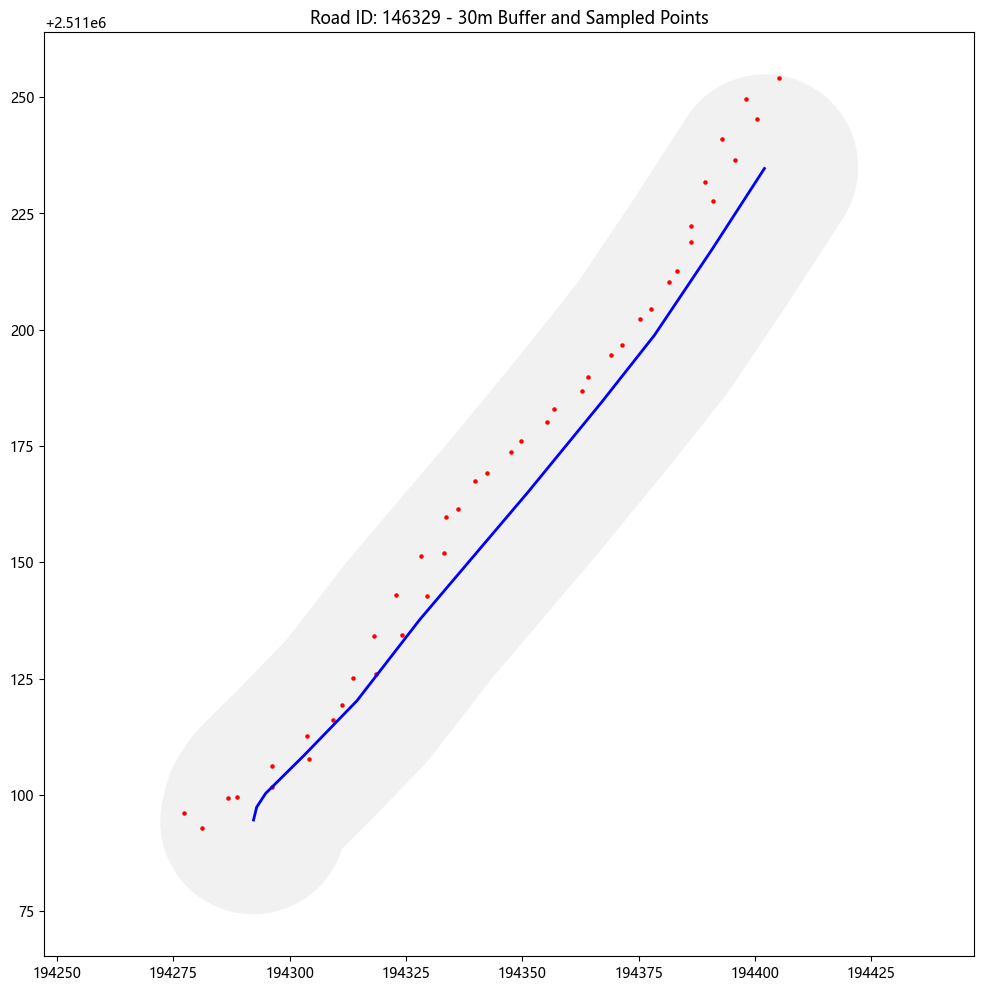

Road statistics:
{'link_id': 146329, 'num_sport': 43, 'buffer_distance': 20}


In [70]:

# 确保投影是 UTM（深圳适用：EPSG:32650）
road_net = road_net.to_crs(epsg=32650)

# ==== 2. 参数设置 ====
buffer_distance = 20  # 单位：米
selected_link_id = 146329

# ==== 3. 筛选目标道路 ====
selected_road = road_net[road_net['new_id'] == selected_link_id]

# ==== 4. 绘制与统计 ====
fig, ax = plt.subplots(figsize=(12, 12))

for idx, road in selected_road.iterrows():
    buffer_50m = road.geometry.buffer(buffer_distance)

    # 筛选落入缓冲区的运动点（确保 points_gdf 已是 GeoDataFrame 且同为EPSG:32649）
    points_in_buffer = points_gdf[points_gdf.geometry.within(buffer_50m)]
    num_points_in_buffer = len(points_in_buffer)

    # 更新统计字段（若尚未存在 num_sport 列，可先初始化）
    if "num_sport" not in road_net.columns:
        road_net["num_sport"] = 0
    road_net.loc[idx, "num_sport"] = num_points_in_buffer

    # 可视化道路、缓冲区、点
    gpd.GeoSeries([road.geometry]).plot(ax=ax, color="blue", linewidth=2, label=f"Road {road['new_id']}")
    gpd.GeoSeries([buffer_50m]).plot(ax=ax, color="lightgray", alpha=0.3)
    points_in_buffer.plot(ax=ax, color="red", markersize=5)

ax.set_title(f"Road ID: {selected_link_id} - 30m Buffer and Sampled Points")
plt.axis("equal")
plt.show()

# ==== 5. 输出结果 ====
road_stats = {
    "link_id": selected_link_id,
    "num_sport": num_points_in_buffer,
    "buffer_distance": buffer_distance
}
print("Road statistics:")
print(road_stats)

In [39]:
import geopandas as gpd
from tqdm import tqdm

# 初始化字段
for col in ["num_sport_10", "num_sport_20", "num_sport_30"]:
    if col not in road_net.columns:
        road_net[col] = 0

# 创建空间索引（只需一次，极大提速）
points_sindex = points_gdf.sindex

# 选取前1000条道路
top_1000_roads = road_net.head(1000)

# 缓冲距离列表
buffer_distances = [10, 20, 30]

# 主循环
for idx, road in tqdm(top_1000_roads.iterrows(), total=len(top_1000_roads), desc="Processing Roads", unit="road"):
    for dist in buffer_distances:
        buffer_geom = road.geometry.buffer(dist)

        # 使用空间索引先做bbox粗筛（大幅加速）
        possible_matches_index = list(points_sindex.intersection(buffer_geom.bounds))
        possible_matches = points_gdf.iloc[possible_matches_index]

        # 再做精准的 within 判断
        precise_matches = possible_matches[possible_matches.geometry.within(buffer_geom)]

        # 写入字段
        road_net.at[idx, f"num_sport_{dist}"] = len(precise_matches)
top_1000_roads

Processing Roads: 100%|█████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 640.51road/s]


,link_id,oneway,Direction,name,class,length,lanes,free_speed,capacity,link_types,...,allow_uses,dirname,UTM_prj,new_id,mm_len,geometry,num_sport,num_sport_10,num_sport_20,num_sport_30
0,29.0,FT,1.0,嘉宾路,城市主干路,84.35005,2.0,60.0,1600.0,secondary,...,auto;bike;walk,深圳市,UTM84-50N,1,84.350051,"LINESTRING (202539.815 2495642.37, 202545.557 ...",0,0,0,0
1,330130.0,FT,1.0,嘉宾路,城市主干路,97.89807,2.0,60.0,1600.0,secondary,...,auto;bike;walk,深圳市,UTM84-50N,2,97.898071,"LINESTRING (202442.527 2495631.464, 202451.359...",0,0,0,0
2,333691.0,FT,1.0,None,城市支路,202.35069,1.0,30.0,1000.0,residential,...,auto;bike;walk,深圳市,UTM84-50N,3,202.350686,"LINESTRING (202539.815 2495642.37, 202536.814 ...",0,0,0,0
3,30.0,FT,1.0,嘉宾路,城市主干路,90.16309,2.0,60.0,1600.0,secondary,...,auto;bike;walk,深圳市,UTM84-50N,4,90.163086,"LINESTRING (202623.506 2495652.874, 202645.168...",0,0,0,0
4,32712.0,1,0.0,None,城市支路,181.39623,1.0,30.0,1000.0,residential,...,auto;bike;walk,深圳市,UTM84-50N,5,181.396227,"LINESTRING (202621.611 2495471.496, 202623.017...",0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,99735.0,FT,1.0,沙井路,城市主干路,10.11678,2.0,60.0,1600.0,secondary,...,auto;bike;walk,深圳市,UTM84-50N,996,10.116776,"LINESTRING (171231.206 2516200.854, 171227.404...",0,0,0,0
996,503.0,FT,1.0,沙井南环路,城市主干路,24.88180,2.0,60.0,1600.0,secondary,...,auto;bike;walk,深圳市,UTM84-50N,997,24.881799,"LINESTRING (171220.62 2516193.144, 171211.018 ...",0,0,0,0
997,165235.0,FT,1.0,None,人行道路,9.44098,1.0,5.0,800.0,footway,...,walk,深圳市,UTM84-50N,998,9.440982,"LINESTRING (171223.121 2516202.248, 171220.62 ...",0,0,0,0
998,165236.0,FT,1.0,None,人行道路,7.69426,1.0,5.0,800.0,footway,...,walk,深圳市,UTM84-50N,999,7.694257,"LINESTRING (171220.62 2516193.144, 171216.906 ...",0,0,0,0


In [71]:
import geopandas as gpd
from tqdm import tqdm

# 确保坐标系一致
assert road_net.crs == points_gdf.crs

# 初始化字段
for dist in [10, 20, 30]:
    col_name = f"num_sport_{dist}"
    if col_name not in road_net.columns:
        road_net[col_name] = 0

# 对每个距离做缓冲区并sjoin
for dist in [10, 20, 30]:
    print(f"🚀 处理 {dist}m 缓冲区")
    road_net[f"buffer_{dist}"] = road_net.geometry.buffer(dist)
    buffer_gdf = gpd.GeoDataFrame(road_net.drop(columns='geometry'), geometry=road_net[f"buffer_{dist}"], crs=road_net.crs)

    # 做空间连接：哪些点落在哪个缓冲区里
    joined = gpd.sjoin(points_gdf, buffer_gdf, predicate="within", how="inner")

    # 统计每条边的点数（index_right 是匹配到的边 index）
    counts = joined.groupby("index_right").size()

    # 写入统计字段
    for idx, count in counts.items():
        road_net.at[idx, f"num_sport_{dist}"] = count

    # 清理中间列
    road_net = road_net.drop(columns=f"buffer_{dist}")


🚀 处理 10m 缓冲区
🚀 处理 20m 缓冲区
🚀 处理 30m 缓冲区


In [72]:
import numpy as np

# 1. 计算长度（若尚未存在）
if 'length' not in road_net.columns:
    road_net['length'] = road_net.geometry.length

# 2. 对每个缓冲尺度做对数归一化
for dist in [10, 20, 30]:
    count_col = f"num_sport_{dist}"
    log_col = f"log_d{dist}"
    norm_col = f"log_d{dist}_norm"

    # 计算单位长度的运动密度
    density = road_net[count_col] / road_net["length"]
    road_net[log_col] = np.log(density + 1e-6)  # 加平滑因子防止 log(0)

    # 归一化
    min_val = road_net[log_col].min()
    max_val = road_net[log_col].max()
    road_net[norm_col] = (road_net[log_col] - min_val) / (max_val - min_val + 1e-9)

    # 删除对数字段，只保留归一化结果
    road_net = road_net.drop(columns=log_col)


In [73]:
road_net

,link_id,oneway,Direction,name,class,length,lanes,free_speed,capacity,link_types,...,new_id,mm_len,geometry,num_sport,num_sport_10,num_sport_20,num_sport_30,log_d10_norm,log_d20_norm,log_d30_norm
0,29.0,FT,1.0,嘉宾路,城市主干路,84.35005,2.0,60.0,1600.0,secondary,...,1,84.350051,"LINESTRING (202539.815 2495642.37, 202545.557 ...",0,28,79,121,0.638970,0.666384,0.674956
1,330130.0,FT,1.0,嘉宾路,城市主干路,97.89807,2.0,60.0,1600.0,secondary,...,2,97.898071,"LINESTRING (202442.527 2495631.464, 202451.359...",0,20,88,126,0.614571,0.664394,0.669792
2,333691.0,FT,1.0,None,城市支路,202.35069,1.0,30.0,1000.0,residential,...,3,202.350686,"LINESTRING (202539.815 2495642.37, 202536.814 ...",0,2659,4369,6545,0.823858,0.818456,0.823297
3,30.0,FT,1.0,嘉宾路,城市主干路,90.16309,2.0,60.0,1600.0,secondary,...,4,90.163086,"LINESTRING (202623.506 2495652.874, 202645.168...",0,25,94,132,0.629924,0.671579,0.675926
4,32712.0,1,0.0,None,城市支路,181.39623,1.0,30.0,1000.0,residential,...,5,181.396227,"LINESTRING (202621.611 2495471.496, 202623.017...",0,28,58,81,0.600484,0.614298,0.619391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146327,344297.0,FT,1.0,None,自行车道,107.39451,1.0,5.0,800.0,cycleway,...,146328,107.394514,"LINESTRING (188139.947 2524159.641, 188143.301...",0,1,20,24,0.459351,0.588102,0.586434
146328,344825.0,FT,1.0,None,人行道路,179.19024,1.0,5.0,800.0,footway,...,146329,179.190236,"LINESTRING (194402.199 2511234.928, 194390.841...",43,36,43,48,0.613730,0.600389,0.595061
146329,345048.0,FT,1.0,None,人行道路,137.13006,1.0,5.0,800.0,footway,...,146330,137.130065,"LINESTRING (190738.748 2495177.519, 190732.31 ...",0,4,8,12,0.516741,0.531849,0.541795
146330,345055.0,FT,1.0,None,人行道路,138.57457,1.0,5.0,800.0,footway,...,146331,138.574571,"LINESTRING (190744.483 2495113.512, 190740.252...",0,21,31,37,0.599559,0.596988,0.594907


In [75]:
# 如果存在 'num_sport' 字段，删掉它
if 'num_sport' in road_net.columns:
    road_net = road_net.drop(columns='num_sport')

road_net.to_file("SZ_road_net_sport_density.geojson", driver="GeoJSON")
print("已完成裁剪 + 条件筛选，并导出为 GeoJSON")


已完成裁剪 + 条件筛选，并导出为 GeoJSON


# 路网指标

In [76]:
import geopandas as gpd

# 1. 读取裁剪 + 密度处理后的路网（包含 num_sport_10/20/30 和 log_d*_norm）
road_net = gpd.read_file("SZ_road_net_sport_density.geojson")

# 2. 删除冗余字段 'num_sport'（如果存在）
if 'num_sport' in road_net.columns:
    road_net = road_net.drop(columns='num_sport')

print(f"✅ 已成功读取路网，共 {len(road_net)} 条边")


✅ 已成功读取路网，共 146332 条边


⚙️ 计算全局 Degree 中心度...


100%|███████████████████████████████████████████████████████████████████████| 146332/146332 [00:03<00:00, 38288.39it/s]


📍 计算局部 Degree 中心度（800m）...


100%|███████████████████████████████████████████████████████████████████████| 146332/146332 [00:04<00:00, 35596.42it/s]


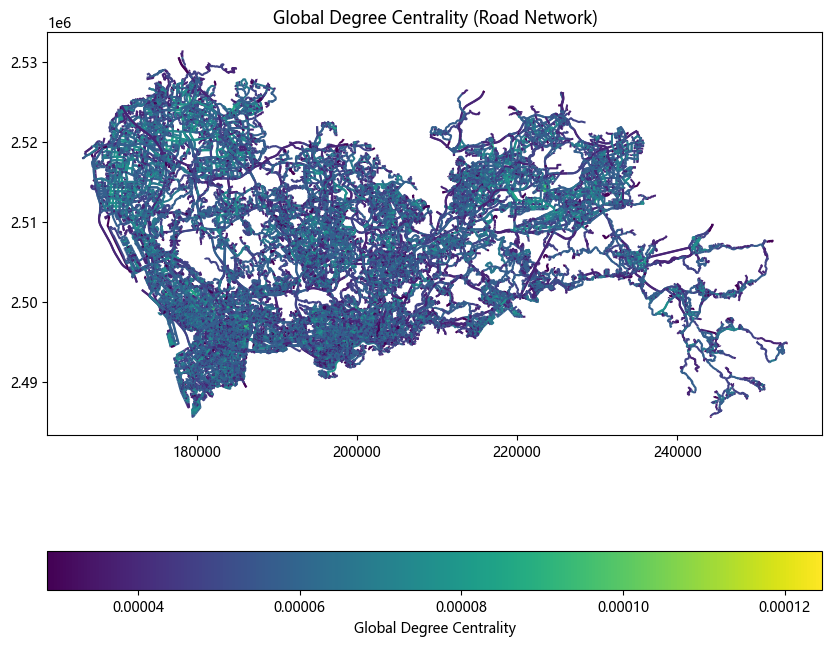

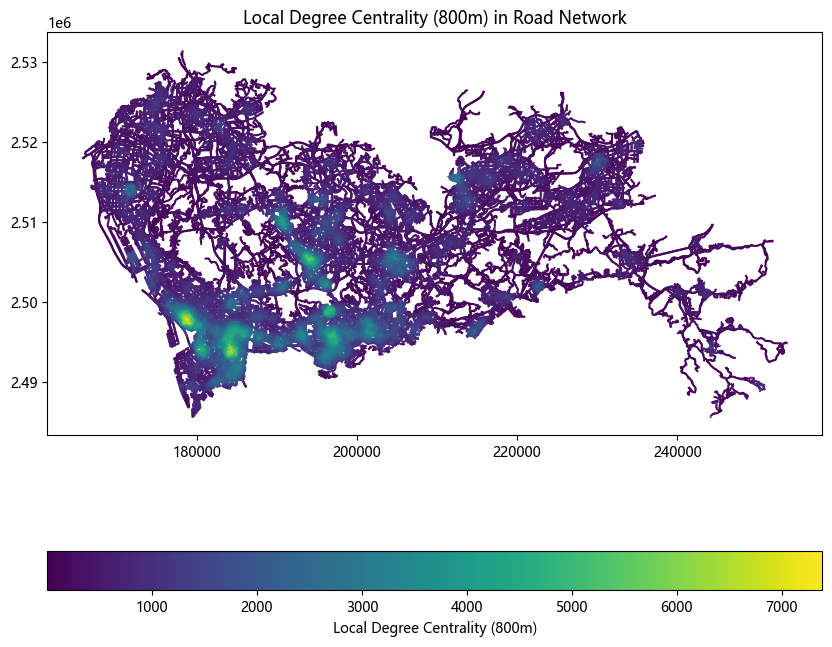

In [77]:
import geopandas as gpd
import networkx as nx
from shapely.geometry import LineString, MultiLineString
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.spatial import KDTree
from joblib import Parallel, delayed
import multiprocessing

# ==== 读取路网数据 ====
# road_net = gpd.read_file("你的路网.shp").to_crs(epsg=32649)

# ==== 1. 构建网络图 ====
G = nx.Graph()
for _, row in road_net.iterrows():
    geom = row['geometry']
    if isinstance(geom, LineString):
        start = geom.coords[0]
        end = geom.coords[-1]
        G.add_edge(start, end)
    elif isinstance(geom, MultiLineString):
        for line in geom.geoms:
            start = line.coords[0]
            end = line.coords[-1]
            G.add_edge(start, end)

node_list = list(G.nodes)
nodes_coords = np.array(node_list)
tree = KDTree(nodes_coords)

# ==== 2. 全局 Degree 中心度 ====
print("⚙️ 计算全局 Degree 中心度...")
deg_centrality = nx.degree_centrality(G)

def get_deg_for_road(row, deg_dict):
    geom = row.geometry
    total = 0
    if isinstance(geom, LineString):
        total += deg_dict.get(geom.coords[0], 0)
        total += deg_dict.get(geom.coords[-1], 0)
    elif isinstance(geom, MultiLineString):
        for line in geom.geoms:
            total += deg_dict.get(line.coords[0], 0)
            total += deg_dict.get(line.coords[-1], 0)
    return total

tqdm.pandas()
road_net['deg_C'] = road_net.progress_apply(lambda row: get_deg_for_road(row, deg_centrality), axis=1)

# ==== 3. 局部 Degree 中心度（800m）====
print("📍 计算局部 Degree 中心度（800m）...")
local_deg_dict = {}
for i, node in enumerate(tqdm(node_list, desc="局部 Degree")):
    idxs = tree.query_ball_point(nodes_coords[i], 800)
    neighbors = [node_list[j] for j in idxs]
    local_deg_dict[node] = sum(G.degree[n] for n in neighbors)

def get_local_deg(row):
    geom = row.geometry
    total = 0
    if isinstance(geom, LineString):
        total += local_deg_dict.get(geom.coords[0], 0)
        total += local_deg_dict.get(geom.coords[-1], 0)
    elif isinstance(geom, MultiLineString):
        for line in geom.geoms:
            total += local_deg_dict.get(line.coords[0], 0)
            total += local_deg_dict.get(line.coords[-1], 0)
    return total

road_net['800_deg_C'] = road_net.progress_apply(get_local_deg, axis=1)

# 全局度中心度可视化
fig, ax = plt.subplots(figsize=(10, 10))
road_net.plot(ax=ax, column='deg_C', legend=True,
              legend_kwds={'label': "Global Degree Centrality", 'orientation': "horizontal"})
plt.title("Global Degree Centrality (Road Network)")
plt.show()

# 局部度中心度可视化
fig, ax = plt.subplots(figsize=(10, 10))
road_net.plot(ax=ax, column='800_deg_C', legend=True,
              legend_kwds={'label': "Local Degree Centrality (800m)", 'orientation': "horizontal"})
plt.title("Local Degree Centrality (800m) in Road Network")
plt.show()

In [84]:
import geopandas as gpd
import networkx as nx
from shapely.geometry import LineString, MultiLineString
import numpy as np
from tqdm import tqdm
from scipy.spatial import KDTree

# === 构图（G 已提前通过 momepy 建好） ===
nodes_coords = np.array(list(G.nodes))
tree = KDTree(nodes_coords)

# === 4. 计算近似全局介数中心度（节点级） ===
print("⏳ 计算近似介数中心度中...")
node_betweenness = nx.betweenness_centrality(G, k=1000, seed=42)

# 计算路段两端节点的中心度之和
def global_betweenness_sum(row, node_betweenness):
    geom = row.geometry
    total = 0
    if isinstance(geom, LineString):
        total += node_betweenness.get(tuple(geom.coords[0]), 0)
        total += node_betweenness.get(tuple(geom.coords[-1]), 0)
    elif isinstance(geom, MultiLineString):
        for line in geom.geoms:
            total += node_betweenness.get(tuple(line.coords[0]), 0)
            total += node_betweenness.get(tuple(line.coords[-1]), 0)
    return total

# 计算中点为中心的 800m 局部中心度
def local_betweenness_sum(row, node_betweenness, tree, nodes_coords, threshold=800):
    geom = row.geometry
    points = []

    if isinstance(geom, LineString):
        mid = len(geom.coords) // 2
        points = [geom.coords[mid]]
    elif isinstance(geom, MultiLineString):
        for line in geom.geoms:
            mid = len(line.coords) // 2
            points.append(line.coords[mid])
    
    total = 0
    for pt in points:
        idxs = tree.query_ball_point(pt, threshold)
        for idx in idxs:
            node = tuple(nodes_coords[idx])
            total += node_betweenness.get(node, 0)
    return total

# === 7. 应用计算 ===
tqdm.pandas()

road_net['betw1000K'] = road_net.progress_apply(
    lambda row: global_betweenness_sum(row, node_betweenness), axis=1)

road_net['betw_800m'] = road_net.progress_apply(
    lambda row: local_betweenness_sum(row, node_betweenness, tree, nodes_coords), axis=1)



⏳ 计算近似介数中心度中...


100%|████████████████████████████████████████████████████████████████████████| 146332/146332 [00:39<00:00, 3680.19it/s]


In [90]:
# === 计算节点级接近中心度（全图） ===
print("⏳ 计算接近中心度中...")
node_closeness = nx.closeness_centrality(G)

# === 计算路段两端节点的接近中心度之和 ===
def global_closeness_sum(row, node_closeness):
    geom = row.geometry
    total = 0
    if isinstance(geom, LineString):
        total += node_closeness.get(tuple(geom.coords[0]), 0)
        total += node_closeness.get(tuple(geom.coords[-1]), 0)
    elif isinstance(geom, MultiLineString):
        for line in geom.geoms:
            total += node_closeness.get(tuple(line.coords[0]), 0)
            total += node_closeness.get(tuple(line.coords[-1]), 0)
    return total

# === 计算中点为中心的800m邻域接近中心度总和 ===
def local_closeness_sum(row, node_closeness, tree, nodes_coords, threshold=800):
    geom = row.geometry
    points = []

    if isinstance(geom, LineString):
        mid = len(geom.coords) // 2
        points = [geom.coords[mid]]
    elif isinstance(geom, MultiLineString):
        for line in geom.geoms:
            mid = len(line.coords) // 2
            points.append(line.coords[mid])
    
    total = 0
    for pt in points:
        idxs = tree.query_ball_point(pt, threshold)
        for idx in idxs:
            node = tuple(nodes_coords[idx])
            total += node_closeness.get(node, 0)
    return total

# === 应用计算 ===
road_net['clo'] = road_net.progress_apply(
    lambda row: global_closeness_sum(row, node_closeness), axis=1)

road_net['clo_800m'] = road_net.progress_apply(
    lambda row: local_closeness_sum(row, node_closeness, tree, nodes_coords), axis=1)


⏳ 计算接近中心度中...


100%|████████████████████████████████████████████████████████████████████████| 146332/146332 [00:38<00:00, 3777.73it/s]


In [94]:
from tqdm import tqdm
import numpy as np
import networkx as nx

tqdm.pandas()  # 启用 tqdm 进度条

# ==== 局部深度函数 ====
def local_depth_800m(row, G, tree, nodes_coords, threshold=800, use_weight=False):
    geom = row.geometry
    points = []

    # 获取中点坐标
    if isinstance(geom, LineString):
        mid = len(geom.coords) // 2
        points = [geom.coords[mid]]
    elif isinstance(geom, MultiLineString):
        for line in geom.geoms:
            mid = len(line.coords) // 2
            points.append(line.coords[mid])

    all_depths = []

    for pt in points:
        # 找到离中点最近的图节点
        _, idx = tree.query(pt)
        origin_node = tuple(nodes_coords[idx])

        # 查询800米内所有图节点
        idxs = tree.query_ball_point(pt, threshold)

        for i in idxs:
            target_node = tuple(nodes_coords[i])
            if target_node == origin_node:
                continue
            try:
                if use_weight:
                    path_len = nx.shortest_path_length(G, source=origin_node, target=target_node, weight='length')
                else:
                    path_len = nx.shortest_path_length(G, source=origin_node, target=target_node)
                all_depths.append(path_len)
            except nx.NetworkXNoPath:
                continue

    return np.mean(all_depths) if all_depths else np.nan

# ==== 应用到 road_net ====
road_net['depth_800m'] = road_net.progress_apply(
    lambda row: local_depth_800m(row, G, tree, nodes_coords, threshold=800, use_weight=False), axis=1
)


100%|████████████████████████████████████████████████████████████████████████| 146332/146332 [1:06:29<00:00, 36.68it/s]


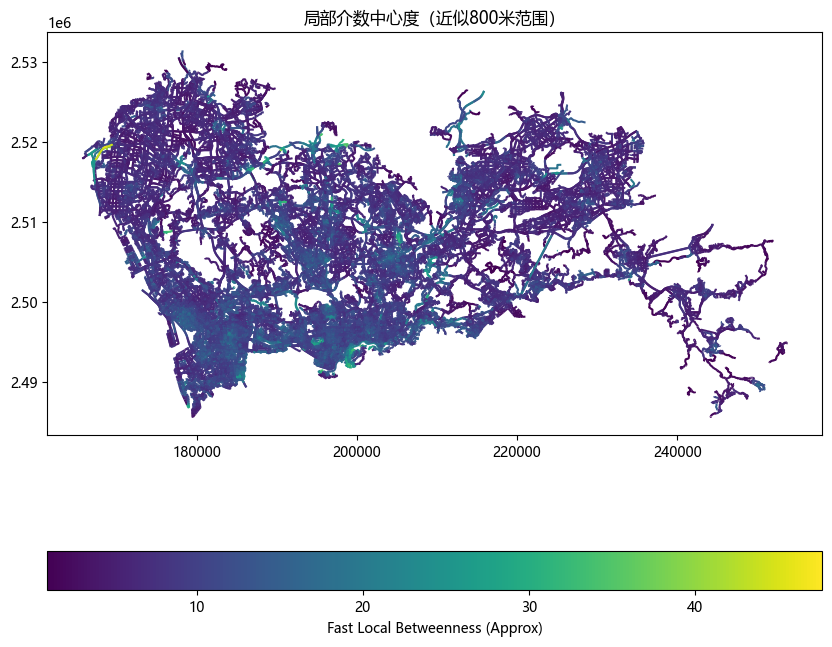

In [96]:
road_net.plot(
    column='depth_800m',
    legend=True,
    legend_kwds={'label': "Fast Local Betweenness (Approx)", 'orientation': "horizontal"},
    figsize=(10, 10)
)
plt.title("局部介数中心度（近似800米范围）")
plt.show()


In [97]:
road_net.to_file("SZ_road_bet_clo.geojson", driver="GeoJSON")
print("已完成裁剪 + 条件筛选，并导出为 GeoJSON")

已完成裁剪 + 条件筛选，并导出为 GeoJSON


In [95]:
road_net

,link_id,oneway,Direction,name,class,length,lanes,free_speed,capacity,link_types,...,log_d30_norm,geometry,deg_C,800_deg_C,fast_local_betweenness,betw1000K,betw_800m,clo,clo_800m,depth_800m
0,29.0,FT,1.0,嘉宾路,城市主干路,84.35005,2.0,60.0,1600.0,secondary,...,0.674956,"LINESTRING (202539.815 2495642.37, 202545.557 ...",0.000058,2386,0.450092,0.000439,0.395289,0.027722,5.868096,11.968397
1,330130.0,FT,1.0,嘉宾路,城市主干路,97.89807,2.0,60.0,1600.0,secondary,...,0.669792,"LINESTRING (202442.527 2495631.464, 202451.359...",0.000058,2439,0.495847,0.000088,0.429459,0.027679,6.027586,12.054945
2,333691.0,FT,1.0,None,城市支路,202.35069,1.0,30.0,1000.0,residential,...,0.823297,"LINESTRING (202539.815 2495642.37, 202536.814 ...",0.000058,2361,0.481944,0.000012,0.430036,0.027848,5.834304,12.294521
3,30.0,FT,1.0,嘉宾路,城市主干路,90.16309,2.0,60.0,1600.0,secondary,...,0.675926,"LINESTRING (202623.506 2495652.874, 202645.168...",0.000058,2323,0.436624,0.000866,0.379640,0.027609,5.686274,11.502336
4,32712.0,1,0.0,None,城市支路,181.39623,1.0,30.0,1000.0,residential,...,0.619391,"LINESTRING (202621.611 2495471.496, 202623.017...",0.000058,2230,0.453929,0.000885,0.400417,0.027892,5.702661,11.454545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146327,344297.0,FT,1.0,None,自行车道,107.39451,1.0,5.0,800.0,cycleway,...,0.586434,"LINESTRING (188139.947 2524159.641, 188143.301...",0.000038,341,0.001760,0.000015,0.001932,0.021289,0.636023,4.701754
146328,344825.0,FT,1.0,None,人行道路,179.19024,1.0,5.0,800.0,footway,...,0.595061,"LINESTRING (194402.199 2511234.928, 194390.841...",0.000029,544,0.669064,0.000010,0.669832,0.033064,1.873227,7.619048
146329,345048.0,FT,1.0,None,人行道路,137.13006,1.0,5.0,800.0,footway,...,0.541795,"LINESTRING (190738.748 2495177.519, 190732.31 ...",0.000058,2672,0.037751,0.000140,0.083896,0.026105,6.034368,11.902597
146330,345055.0,FT,1.0,None,人行道路,138.57457,1.0,5.0,800.0,footway,...,0.594907,"LINESTRING (190744.483 2495113.512, 190740.252...",0.000058,2679,0.095853,0.000256,0.147638,0.026711,6.106585,11.751073


# 街景处理

Processing roads: 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.60road/s]


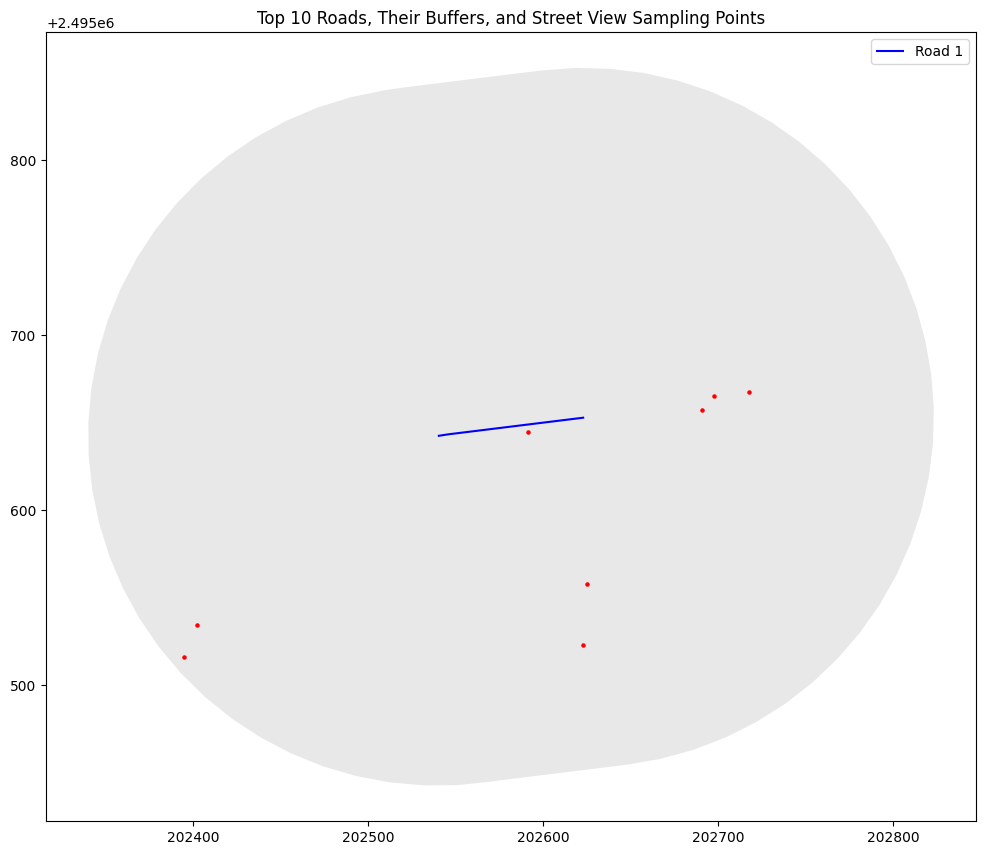

Road 1 summary:
{'road': 33555.6875, 'sidewalk': 10150.5, 'building': 55141.625, 'wall': 1393.1875, 'fence': 4484.9062, 'pole': 1331.3125, 'traffic li': 9.875, 'traffic si': 387.0, 'vegetation': 29782.8438, 'terrain': 930.6562, 'sky': 12094.0312, 'person': 1382.7812, 'rider': 202.1875, 'car': 19109.0, 'truck': 526.4375, 'bus': 338.3438, 'train': 101.5, 'motorcycle': 307.7812, 'bicycle': 1570.3438, 'bg': 0.0}
----------------------------------------


In [3]:
import geopandas as gpd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString, MultiLineString

# 1. 定义需要汇总的字段（可以根据实际情况修改）
fields_to_aggregate = [
    'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic li', 'traffic si',
    'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle', 'bg'
]

# 2. 读取路网和街景采样点数据
road_net = gpd.read_file("SZ_road_bet_clo.geojson")
street_view_gdf = gpd.read_file("Perceived Space\街景_STDC_2024\深圳街景采样点.shp")

# 转换街景采样点坐标系为路网的坐标系
street_view_gdf = street_view_gdf.to_crs(road_net.crs)

# 3. 选择前 10 条路网
top_10_roads = road_net.iloc[:1]

# 4. 创建一个空的字典，用于存储每条路网的汇总结果
aggregated_data_top_10 = {}

# 5. 可视化前 10 条路网、它们的缓冲区和落在缓冲区内的街景采样点
fig, ax = plt.subplots(figsize=(12, 12))

# 遍历前 10 条路网
for idx, road in tqdm(top_10_roads.iterrows(), total=len(top_10_roads), desc="Processing roads", unit="road"):
    # 为每条路网建立 50 米的缓冲区
    buffer_50m = road.geometry.buffer(200)
    
    # 找出落在缓冲区内的街景采样点
    street_view_in_buffer = street_view_gdf[street_view_gdf.geometry.within(buffer_50m)]
    
    # 汇总采样点数据
    road_data = {}
    for field in fields_to_aggregate:
        if field in street_view_in_buffer.columns:
            road_data[field] = street_view_in_buffer[field].mean()
            road_data[field] = round(road_data[field], 4)  # 保留 4 位小数

    # 如果这条路网没有采样点，则使用相邻道路插值
    if len(street_view_in_buffer) == 0:
        # 查找与当前道路相连的路网
        connected_roads = road_net[road_net.geometry.intersects(road.geometry)]
        
        # 如果有相邻道路，进行插值
        if len(connected_roads) > 0:
            for field in fields_to_aggregate:
                if field in connected_roads.columns:
                    road_data[field] = connected_roads[field].mean()
                    road_data[field] = round(road_data[field], 4)
        else:
            # 如果没有相邻道路，使用最接近的道路
            # 计算当前道路与所有其他道路的距离，选择最近的道路
            road_net['distance'] = road_net.geometry.distance(road.geometry)
            nearest_road = road_net.loc[road_net['distance'].idxmin()]
            
            # 获取最接近道路的字段数据
            for field in fields_to_aggregate:
                if field in nearest_road:
                    road_data[field] = nearest_road[field]
                    road_data[field] = round(road_data[field], 4)

    # 保存每条路网的汇总数据
    aggregated_data_top_10[road['new_id']] = road_data  # 用 'Ref' 作为唯一标识符

    # 绘制路网（使用 gpd.GeoSeries.plot 来绘制几何）
    gpd.GeoSeries([road.geometry]).plot(ax=ax, color="blue", linewidth=1.5, label=f"Road {int(road['new_id'])}")

    # 绘制缓冲区
    gpd.GeoSeries([buffer_50m]).plot(ax=ax, color="lightgray", alpha=0.5)

    # 绘制落在缓冲区内的街景采样点
    if len(street_view_in_buffer) > 0:
        street_view_in_buffer.plot(ax=ax, color="red", markersize=5)

# 添加图例和标题
ax.set_title("Top 10 Roads, Their Buffers, and Street View Sampling Points")
ax.legend()

# 显示图形
plt.show()

# 输出前10条路网的汇总结果
for road_id, data in aggregated_data_top_10.items():
    print(f"Road {road_id} summary:")
    print(data)
    print("-" * 40)


In [5]:
import geopandas as gpd
import numpy as np
from tqdm import tqdm

# 1. 定义需要汇总的字段
fields_to_aggregate = [
    'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic li', 'traffic si',
    'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle'
]

# 转换街景采样点坐标系为路网的坐标系
street_view_gdf = street_view_gdf.to_crs(road_net.crs)

# 3. 创建街景采样点的空间索引
points_gdf_sindex = street_view_gdf.sindex

# 4. 为每条道路生成缓冲区并汇聚采样点数据
aggregated_data_all_roads = {}

# 5. 进度条处理所有道路
for idx, road in tqdm(road_net.iterrows(), total=len(road_net), desc="Processing Roads", unit="road"):
    # 为每条路网生成50米的缓冲区
    buffer_50m = road.geometry.buffer(100)
    
    # 使用空间索引查找缓冲区内的采样点
    possible_matches_index = list(points_gdf_sindex.intersection(buffer_50m.bounds))  # 获取与缓冲区有重叠的点索引
    possible_matches = street_view_gdf.iloc[possible_matches_index]  # 选择这些点
    precise_matches = possible_matches[possible_matches.geometry.within(buffer_50m)]  # 精确筛选落在缓冲区内的点
    
    # 汇总采样点数据
    road_data = {}
    for field in fields_to_aggregate:
        if field in precise_matches.columns:
            road_data[field] = precise_matches[field].mean()
            road_data[field] = round(road_data[field], 4)  # 保留 4 位小数
    
    # 如果这条路网没有采样点，则使用相邻道路插值
    if len(precise_matches) == 0:
        # 查找与当前道路相连的路网
        connected_roads = road_net[road_net.geometry.intersects(road.geometry)]
        
        # 如果有相邻道路，进行插值
        if len(connected_roads) > 0:
            for field in fields_to_aggregate:
                if field in connected_roads.columns:
                    road_data[field] = connected_roads[field].mean()
                    road_data[field] = round(road_data[field], 4)
        else:
            # 如果没有相邻道路，使用最接近的道路
            # 计算当前道路与所有其他道路的距离，选择最近的道路
            road_net['distance'] = road_net.geometry.distance(road.geometry)
            nearest_road = road_net.loc[road_net['distance'].idxmin()]
            
            # 获取最接近道路的字段数据
            for field in fields_to_aggregate:
                if field in nearest_road:
                    road_data[field] = nearest_road[field]
                    road_data[field] = round(road_data[field], 4)

    # 保存每条路网的汇总数据
    aggregated_data_all_roads[road['new_id']] = road_data  # 用 'new_id' 作为唯一标识符
    
    # 更新路网数据，添加汇总字段
    for field, value in road_data.items():
        road_net.loc[idx, field] = value  # 更新每条道路的汇总字段

# 输出汇总数据（示例查看前 5 条）
print(road_net[['link_id', 'road', 'sidewalk', 'building', 'car']].head())

Processing Roads: 100%|█████████████████████████████████████████████████████| 146332/146332 [16:27<00:00, 148.11road/s]

    link_id        road    sidewalk    building         car
0      29.0  33742.3500  10738.5500  55631.1500  20223.3000
1  330130.0  31423.7500   7715.0000  47728.2500  21891.0000
2  333691.0  33679.3625  10412.6500  42304.0625  15797.6000
3      30.0  33742.3500  10738.5500  55631.1500  20223.3000
4   32712.0  32984.1250  13183.5417  57198.4583  17419.9583


In [8]:
# 删除 'bg' 字段
road_net = road_net.drop(columns=['bg'])

In [9]:
# 查看road_net1中的所有字段名称
print(road_net.columns)

Index(['link_id', 'oneway', 'Direction', 'name', 'class', 'length', 'lanes',
       'free_speed', 'capacity', 'link_types', 'link_type', 'allow_uses',
       'dirname', 'UTM_prj', 'new_id', 'mm_len', 'num_sport_10',
       'num_sport_20', 'num_sport_30', 'log_d10_norm', 'log_d20_norm',
       'log_d30_norm', 'deg_C', '800_deg_C', 'fast_local_betweenness',
       'betw1000K', 'betw_800m', 'clo', 'clo_800m', 'depth_800m', 'geometry',
       'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic li',
       'traffic si', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car',
       'truck', 'bus', 'train', 'motorcycle', 'bicycle'],
      dtype='object')


In [10]:
road_net.to_file("SZ_road_bet_clo_SVI.geojson", driver="GeoJSON")

原始数据集中的缺失值统计：
length              0
lanes               0
free_speed          0
capacity            0
800_deg_C           0
betw_800m           0
clo                 0
clo_800m            0
depth_800m         24
road            30960
sidewalk        30960
building        30960
wall            30960
fence           30960
pole            30960
traffic li      30960
traffic si      30960
vegetation      30960
terrain         30960
sky             30960
person          30960
rider           30960
car             30960
truck           30960
bus             30960
train           30960
motorcycle      30960
bicycle         30960
link_type           0
log_d20_norm        0
dtype: int64
清理后的数据集中的缺失值统计：
length        0
lanes         0
free_speed    0
capacity      0
800_deg_C     0
betw_800m     0
clo           0
clo_800m      0
depth_800m    0
road          0
sidewalk      0
building      0
wall          0
fence         0
pole          0
traffic li    0
traffic si    0
vegetation    0
terrain  

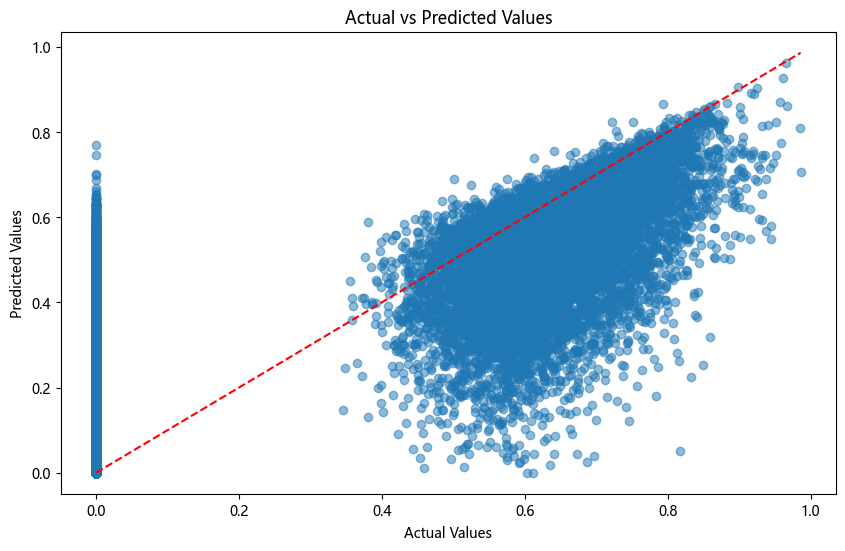

In [102]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 假设 road_net 已经加载并包含所有字段
# 目标变量
target = 'log_d20_norm'

# 2. 处理多模态标签（如 allow_use）
allow_use_options = ['walk', 'bike', 'auto']
for option in allow_use_options:
    road_net[f'allow_{option}'] = road_net['allow_uses'].apply(lambda x: 1 if option in x else 0)

# 3. 提取特征和目标变量
selected_features = [
    'length', 'lanes', 'free_speed', 'capacity', '800_deg_C', 'betw_800m', 
    'clo', 'clo_800m', 'depth_800m','road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic li', 
    'traffic si', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 
    'truck', 'bus', 'train', 'motorcycle', 'bicycle', 'link_type'
]

# 确保所有选择的特征都在数据集中
missing_features = [feature for feature in selected_features if feature not in road_net.columns]
if missing_features:
    raise ValueError(f"以下特征在数据集中缺失: {missing_features}")

# 检查原始数据集中是否有 NaN 值
print("原始数据集中的缺失值统计：")
print(road_net[selected_features + [target]].isnull().sum())

# 删除所有包含 NaN 的数据行
road_net_cleaned = road_net.dropna(subset=selected_features + [target])

# 提取特征和目标变量
X = road_net_cleaned[selected_features]  # 特征
y = road_net_cleaned[target]  # 目标变量

# 检查清理后的数据集中是否有 NaN 值
print("清理后的数据集中的缺失值统计：")
print(X.isnull().sum())
print(y.isnull().sum())

# 如果有分类变量，进行 One-Hot Encoding
if 'link_type' in X.columns:
    X = pd.get_dummies(X, columns=['link_type'], drop_first=True)

# 检查特征值是否全为常数
constant_features = X.columns[X.nunique() == 1]
print("常数特征：", constant_features)
if len(constant_features) > 0:
    X.drop(columns=constant_features, inplace=True)

# 4. 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. 初始化随机森林模型
rf_model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)

# 6. 训练模型
rf_model.fit(X_train, y_train)

# 7. 预测
y_pred = rf_model.predict(X_test)

# 8. 评估模型
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# 9. 特征重要性分析
feature_importances = rf_model.feature_importances_
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)
print(importance_df)

# 10. 散点图可视化预测结果
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # 绘制对角线
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()